# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc

from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
genes = torch.load(
    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
#    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu')
)['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [4]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    'mesangial cell',
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
   # 'endothelial cell'
]

In [5]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
#adata = sc.read_h5ad('../data/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 15728 × 23149
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3'

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/202 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


kidney distal convoluted tubule epithelial cell (807, 5000)
base enrichment
Top central genes: []


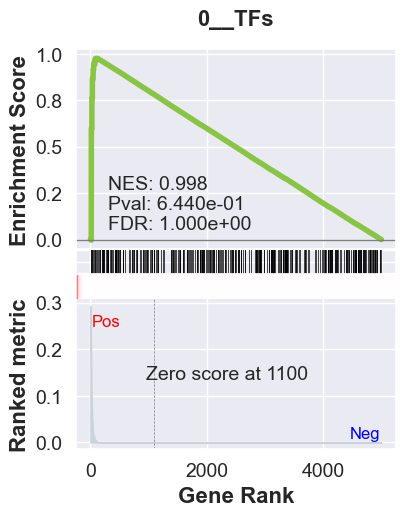

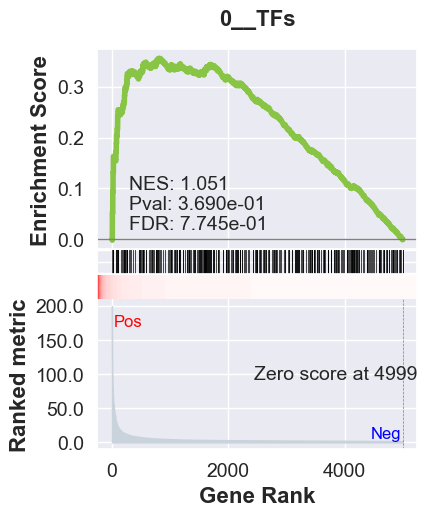

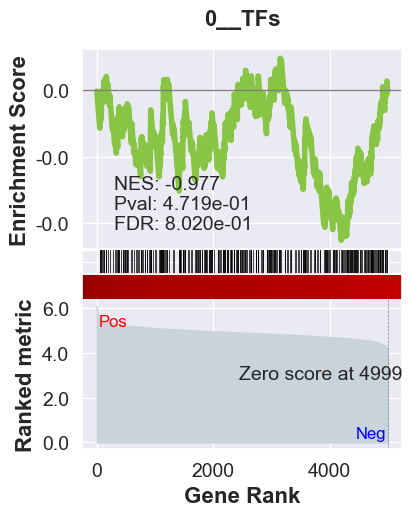

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3565 genes
intersection pct: 0.713
precision:  0.0010623619711281117 
recall:  0.9992590397154713 
random precision: 0.001062203773751226


 98%|█████████▊| 126/128 [00:02<00:00, 53.55it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.96it/s]


Average Precision (AP):  0.0011154383276875675
Area Under Precision-Recall Curve (AUPRC):  0.0011144952207096004
EPR: 1.3963114708240703


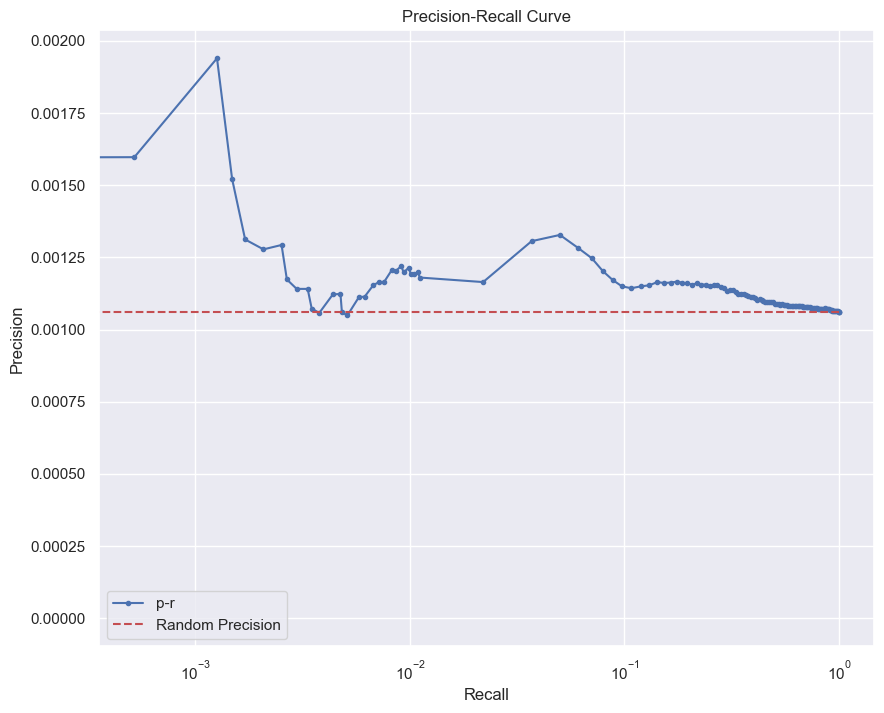

base enrichment
Top central genes: []


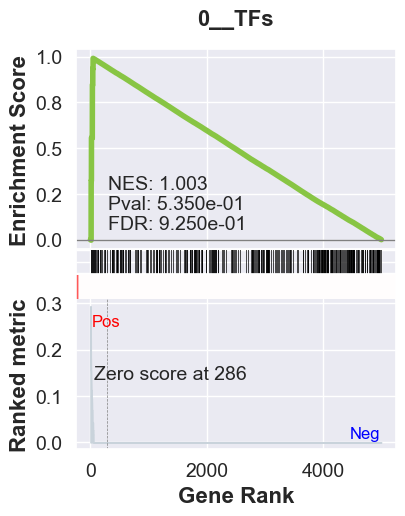

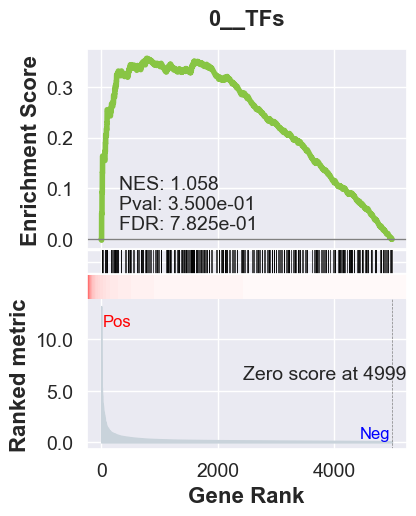

_________________________________________
TF specific enrichment
found some significant results for  8.823529411764707 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3565 genes
intersection pct: 0.713
precision:  0.004540668795146984 
recall:  0.33521043272080614 
random precision: 0.001062203773751226


 98%|█████████▊| 126/128 [00:02<00:00, 52.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.54it/s]


Average Precision (AP):  0.0028625970113570244
Area Under Precision-Recall Curve (AUPRC):  0.002324228938821251
EPR: 4.639463908997815


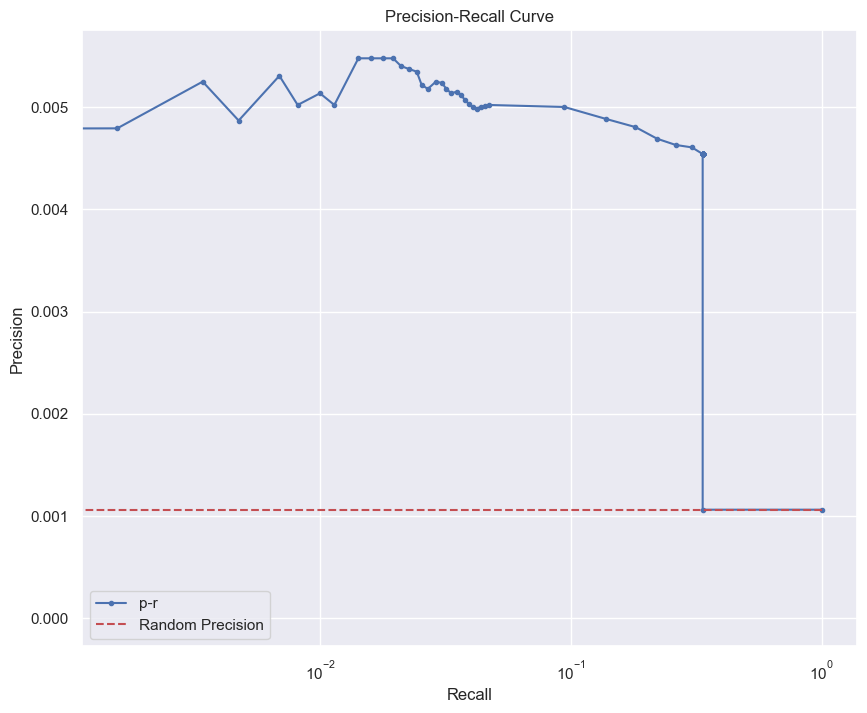

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/61 [00:00<?, ?it/s]

kidney loop of Henle thick ascending limb epithelial cell (243, 5000)
base enrichment
Top central genes: []


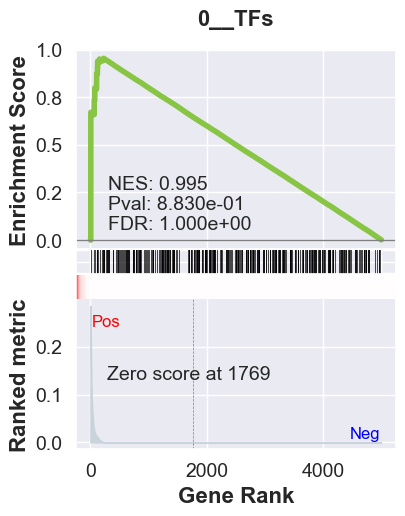

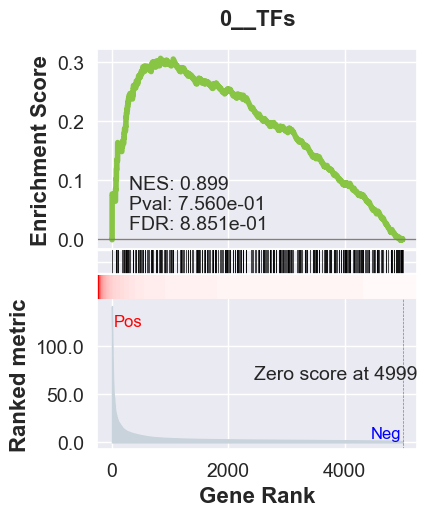

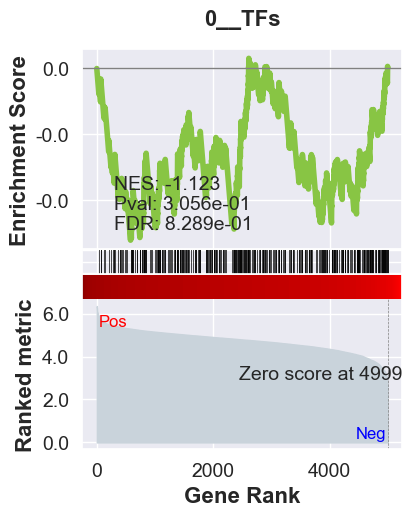

_________________________________________
TF specific enrichment
found some significant results for  2.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3514 genes
intersection pct: 0.7028
precision:  0.0012412273020088827 
recall:  0.9638441489006215 
random precision: 0.0012121008868434197


 99%|█████████▉| 127/128 [00:02<00:00, 46.53it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.57it/s]


Average Precision (AP):  0.0012571779475952932
Area Under Precision-Recall Curve (AUPRC):  0.0012556687254377736
EPR: 1.4350707552515458


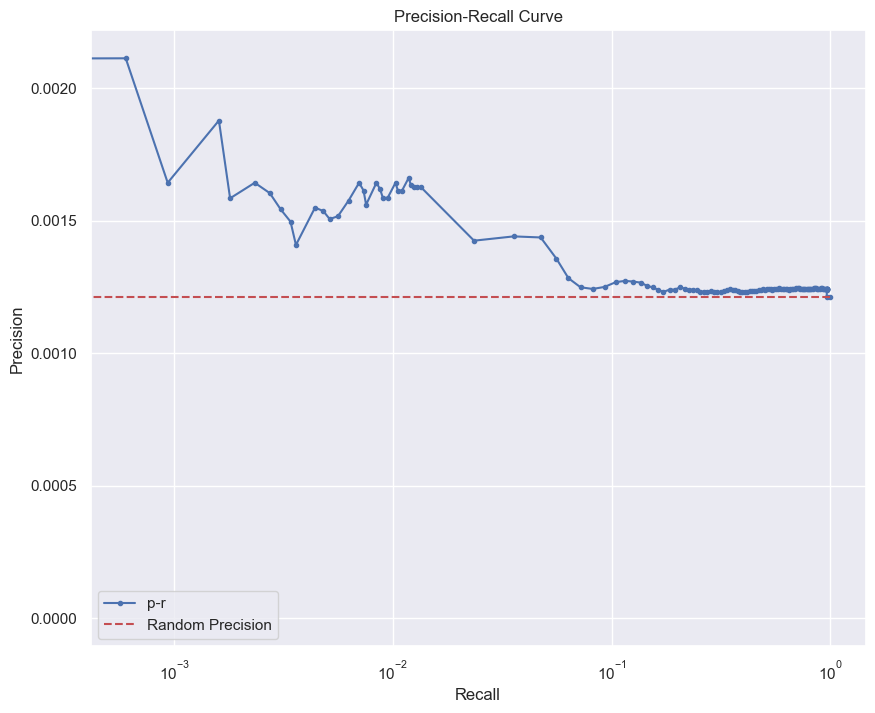

base enrichment
Top central genes: []


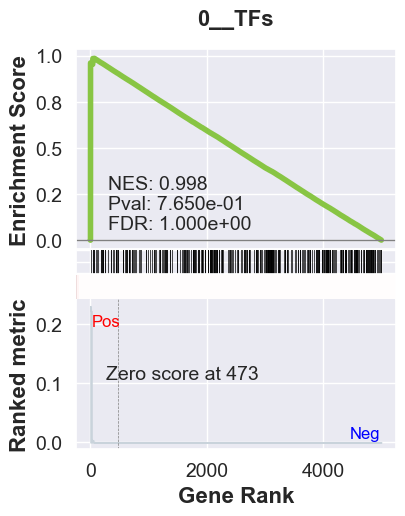

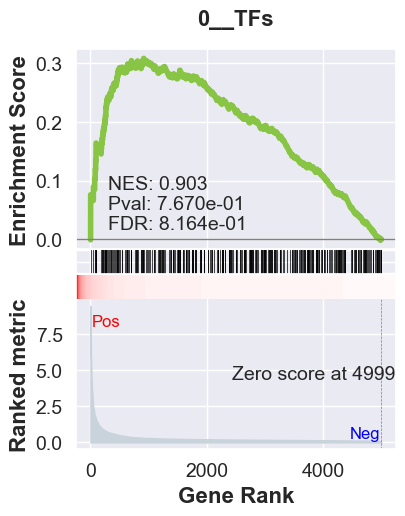

_________________________________________
TF specific enrichment
found some significant results for  2.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3514 genes
intersection pct: 0.7028
precision:  0.006305103022984771 
recall:  0.41108066564191675 
random precision: 0.0012121008868434197


 99%|█████████▉| 127/128 [00:02<00:00, 50.24it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 49.82it/s]


Average Precision (AP):  0.004079482101930073
Area Under Precision-Recall Curve (AUPRC):  0.003448867490858864
EPR: 7.162509214663171


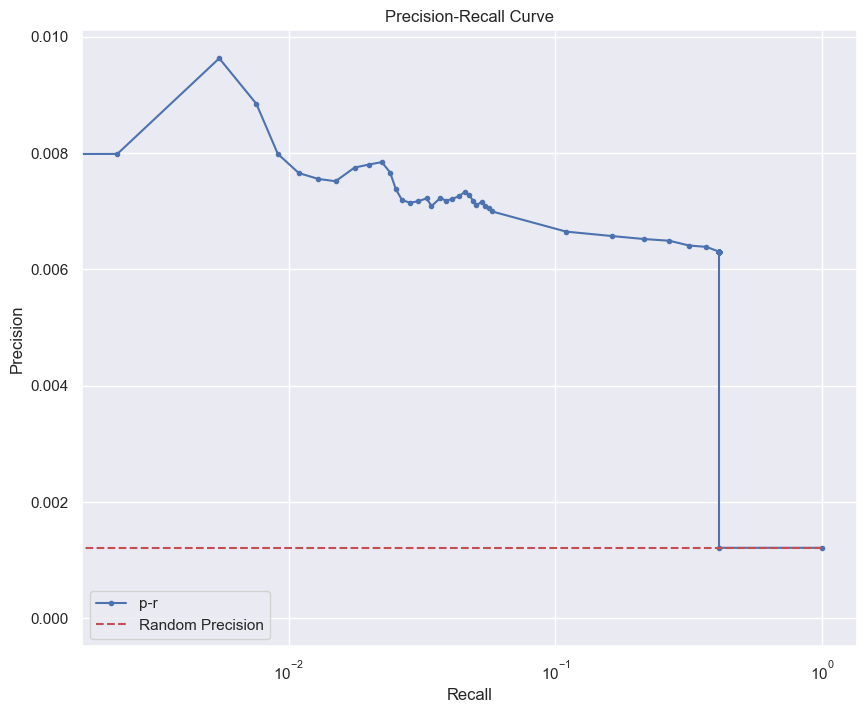

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/83 [00:00<?, ?it/s]

kidney collecting duct principal cell (332, 5000)
base enrichment
Top central genes: []


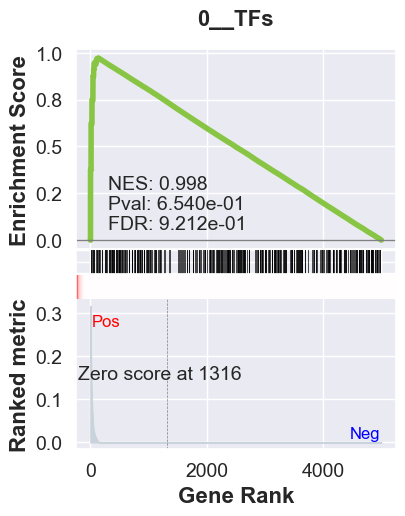

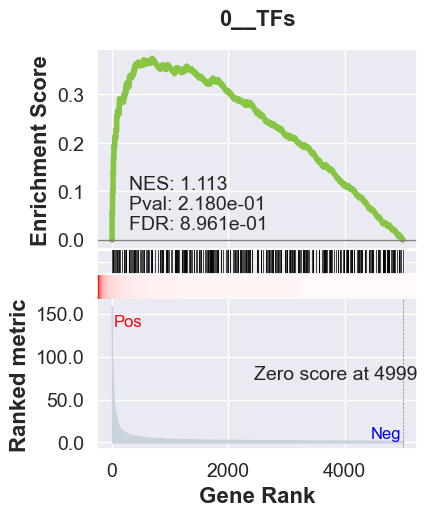

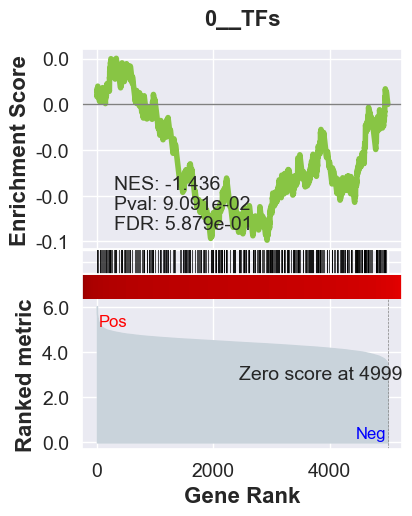

_________________________________________
TF specific enrichment
found some significant results for  5.714285714285714 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3594 genes
intersection pct: 0.7188
precision:  0.001370072406037335 
recall:  0.9953374651731393 
random precision: 0.0013619352909207464


 99%|█████████▉| 127/128 [00:02<00:00, 49.01it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 47.17it/s]


Average Precision (AP):  0.0014477404691345588
Area Under Precision-Recall Curve (AUPRC):  0.0014458264036662962
EPR: 1.1695266752433175


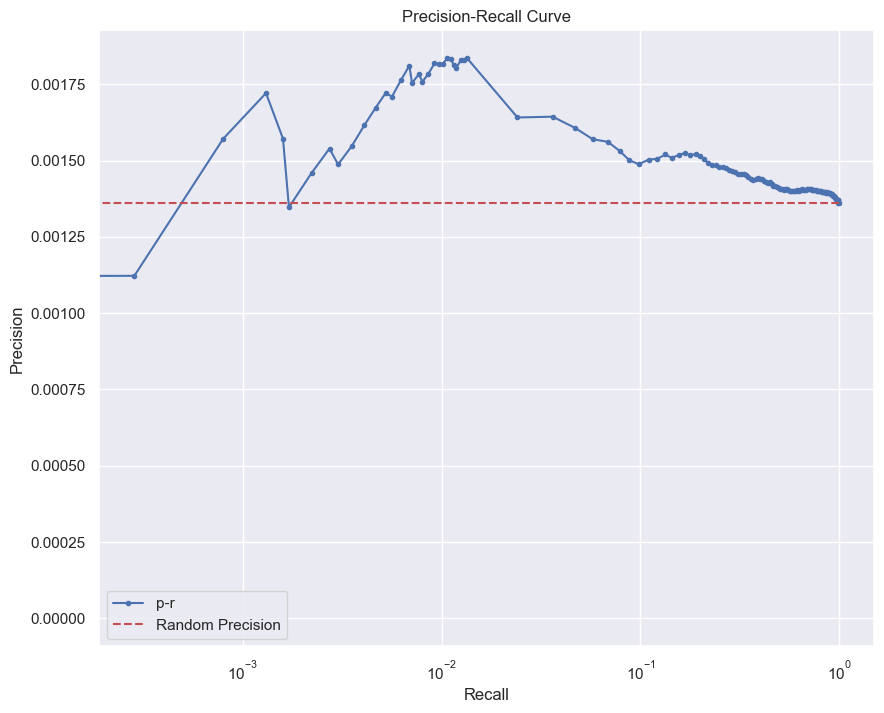

base enrichment
Top central genes: []


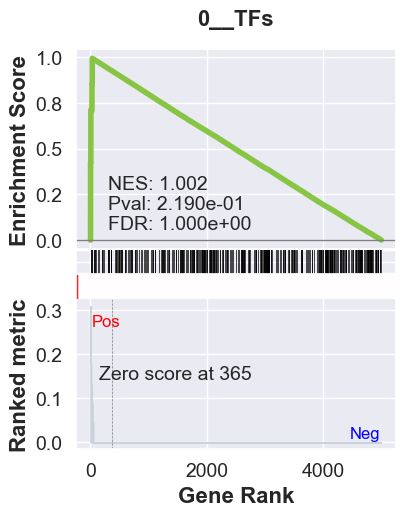

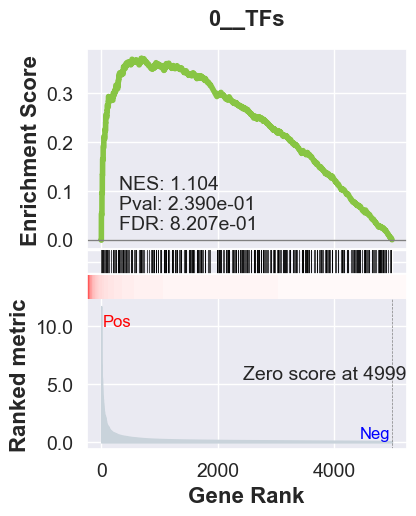

_________________________________________
TF specific enrichment
found some significant results for  2.857142857142857 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3594 genes
intersection pct: 0.7188
precision:  0.007047180629937937 
recall:  0.4427133678285097 
random precision: 0.0013619352909207464


 98%|█████████▊| 125/128 [00:02<00:00, 50.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.70it/s]


Average Precision (AP):  0.004742724783332393
Area Under Precision-Recall Curve (AUPRC):  0.004107387062512978
EPR: 6.784702824605764


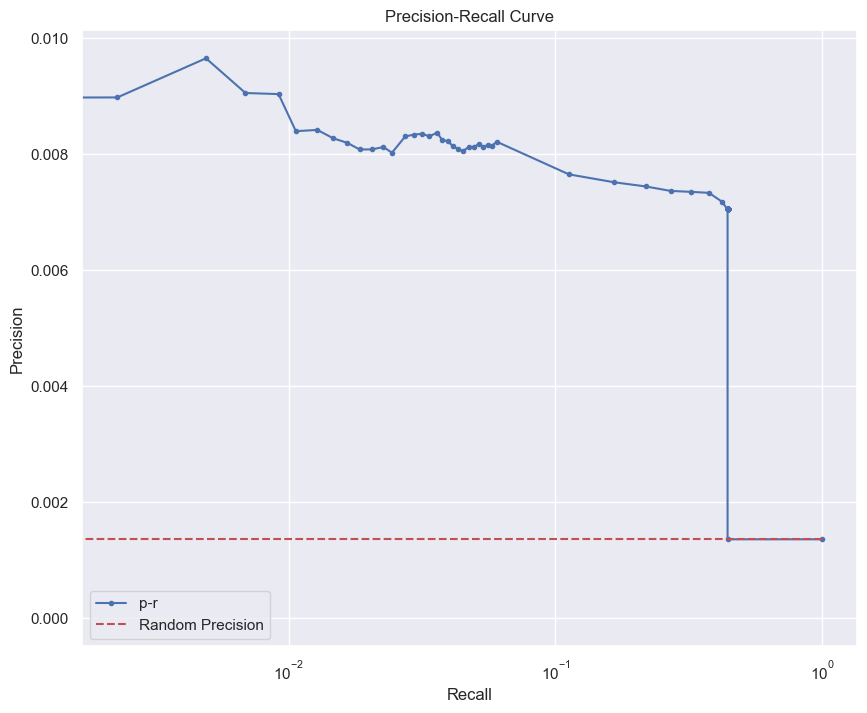

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
num_proc must be <= 7. Reducing num_proc to 7 for dataset of size 7.
[d3graph] WARNING> num_proc must be <= 7. Reducing num_proc to 7 for dataset of size 7.


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/2 [00:00<?, ?it/s]

mesangial cell (7, 4802)
base enrichment
Top central genes: []


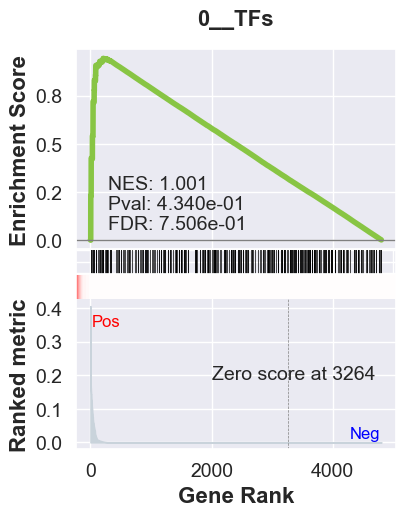

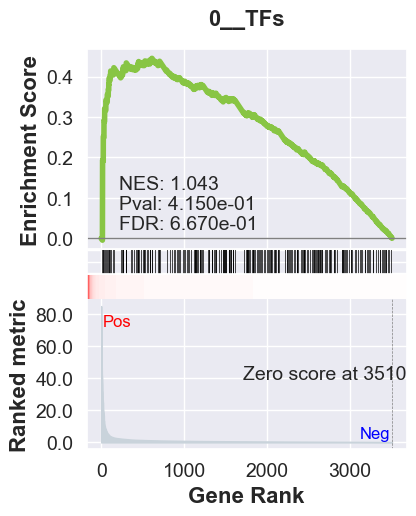

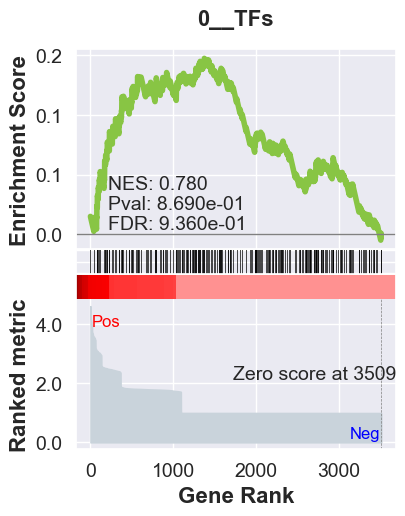

_________________________________________
TF specific enrichment
found some significant results for  9.090909090909092 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3170 genes
intersection pct: 0.6601416076634735
precision:  0.0016249885447755202 
recall:  0.3218562874251497 
random precision: 0.0010639346269509533


 98%|█████████▊| 126/128 [00:01<00:00, 69.19it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 68.84it/s]


Average Precision (AP):  0.0014406218978646437
Area Under Precision-Recall Curve (AUPRC):  0.0013355807980900422
EPR: 2.0270455497068043


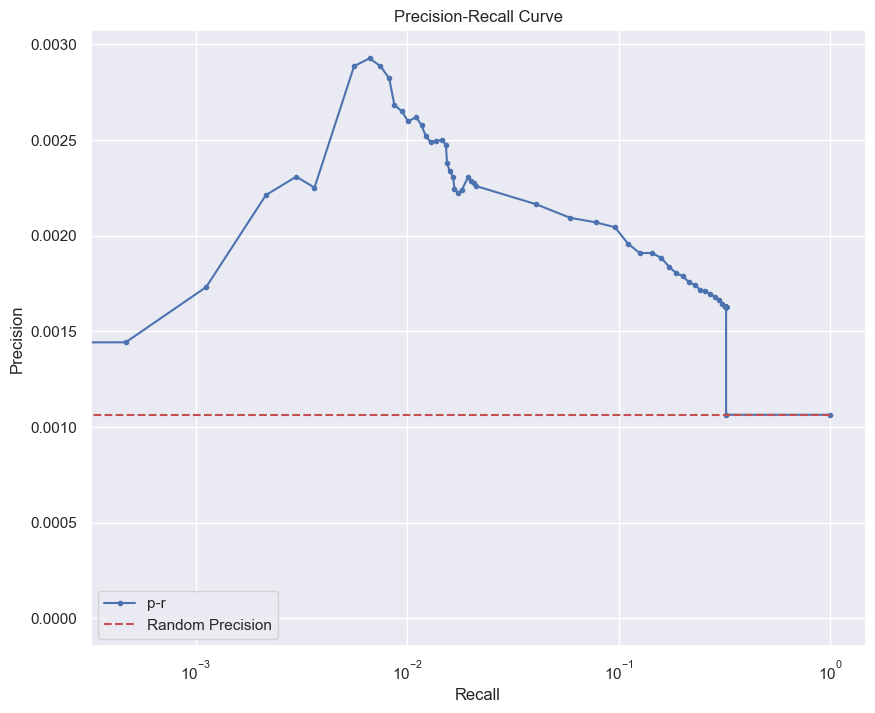

base enrichment
Top central genes: []


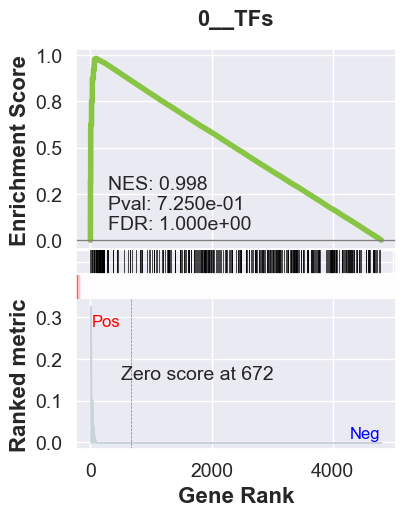

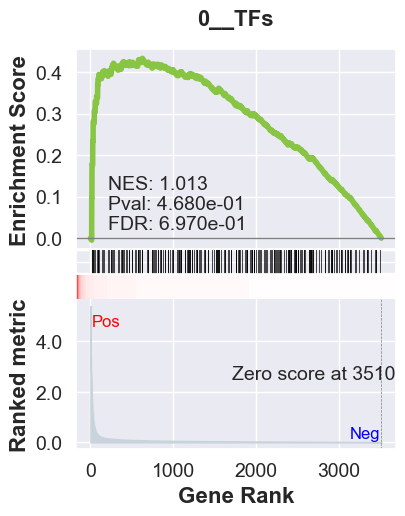

_________________________________________
TF specific enrichment
found some significant results for  2.272727272727273 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3170 genes
intersection pct: 0.6601416076634735
precision:  0.01150364332097868 
recall:  0.17917290419161677 
random precision: 0.0010639346269509533


 94%|█████████▍| 120/128 [00:01<00:00, 69.32it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 68.94it/s]


Average Precision (AP):  0.003666922546305229
Area Under Precision-Recall Curve (AUPRC):  0.0032296055579410254
EPR: 16.153947859905976


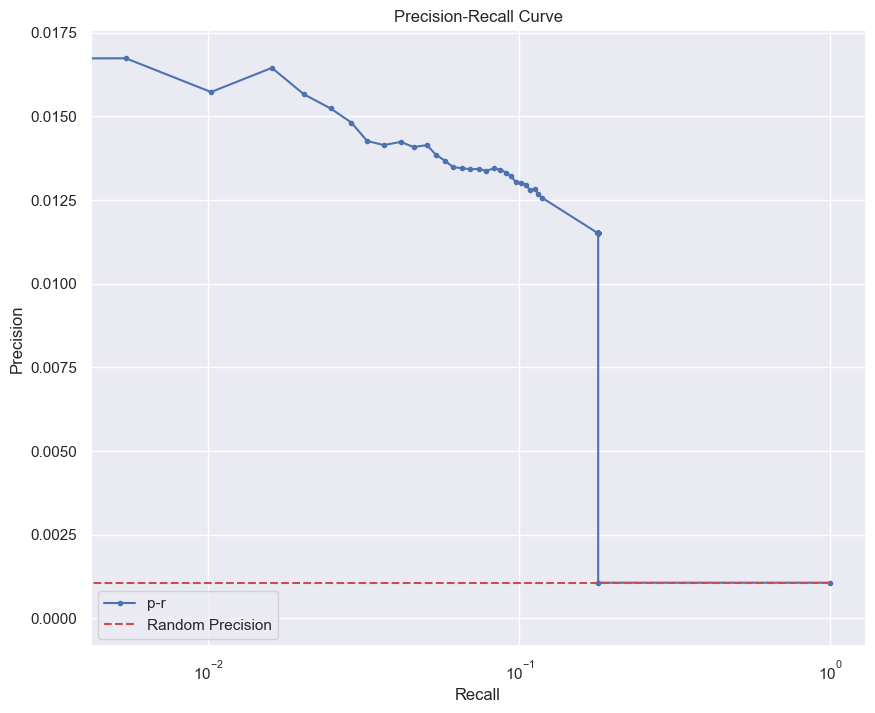

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/51 [00:00<?, ?it/s]

blood vessel smooth muscle cell (202, 5000)
base enrichment
Top central genes: []


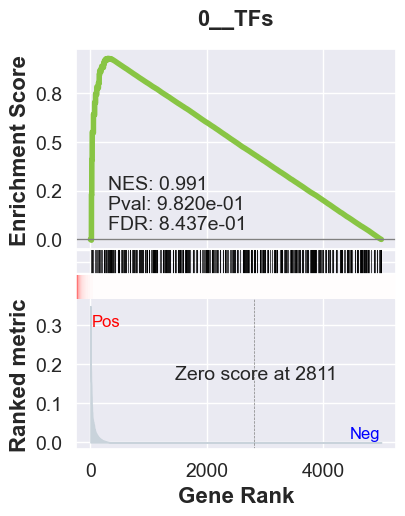

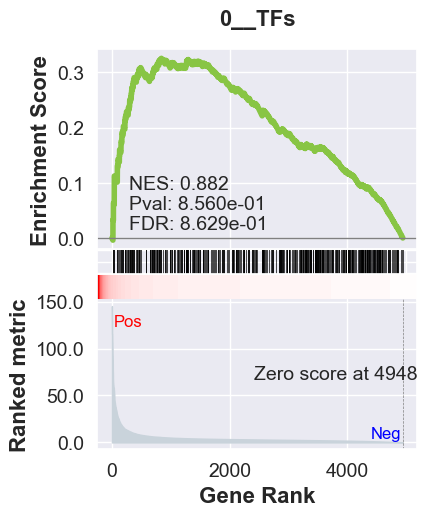

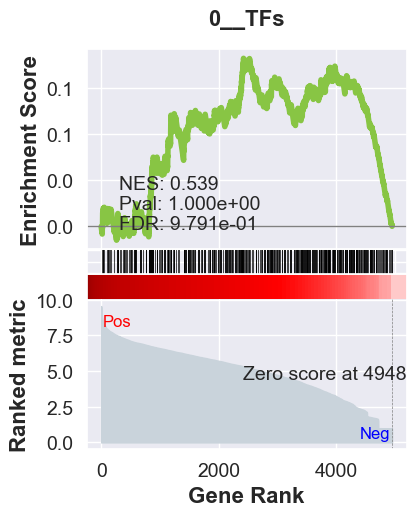

_________________________________________
TF specific enrichment
found some significant results for  12.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3625 genes
intersection pct: 0.725
precision:  0.001901083851801466 
recall:  0.7064420669246528 
random precision: 0.0016719951282636828


 98%|█████████▊| 126/128 [00:02<00:00, 51.19it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.05it/s]


Average Precision (AP):  0.0019679320910460994
Area Under Precision-Recall Curve (AUPRC):  0.001936205513190231
EPR: 0.980183820555321


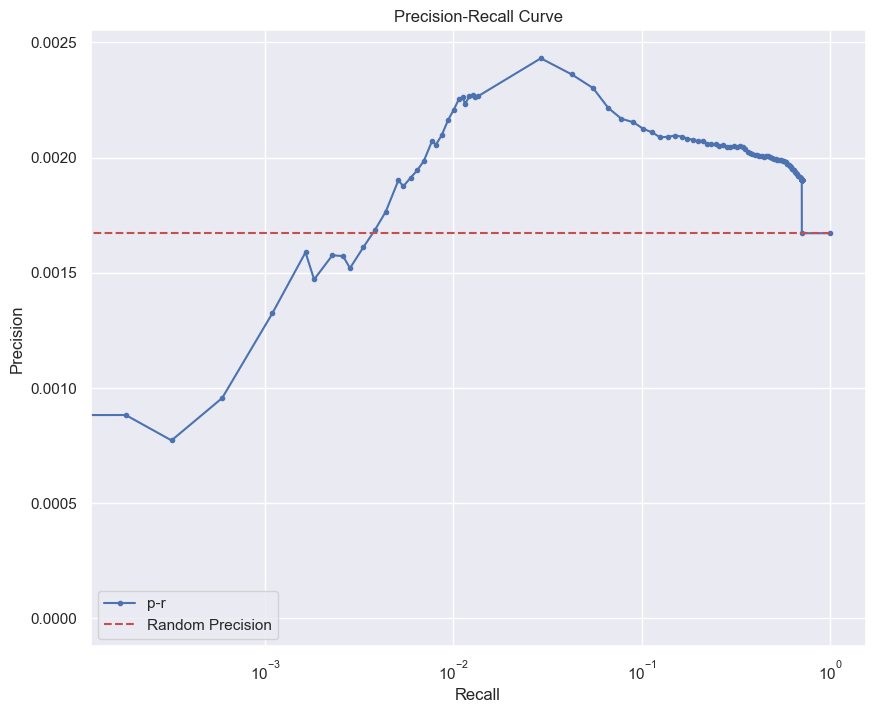

base enrichment
Top central genes: []


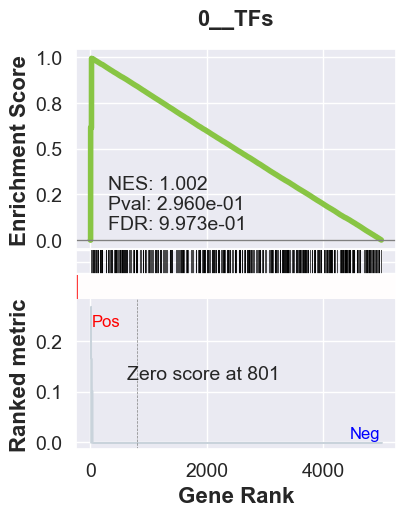

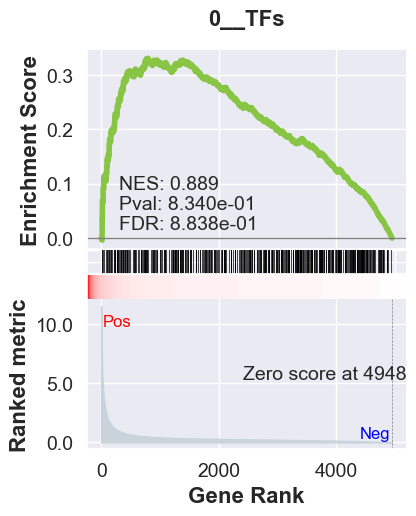

_________________________________________
TF specific enrichment
found some significant results for  1.7857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3625 genes
intersection pct: 0.725
precision:  0.009127600957537927 
recall:  0.34058729797404963 
random precision: 0.0016719951282636828


 98%|█████████▊| 126/128 [00:02<00:00, 51.86it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.68it/s]


Average Precision (AP):  0.005201074621698357
Area Under Precision-Recall Curve (AUPRC):  0.004396827047100844
EPR: 6.402975003177404


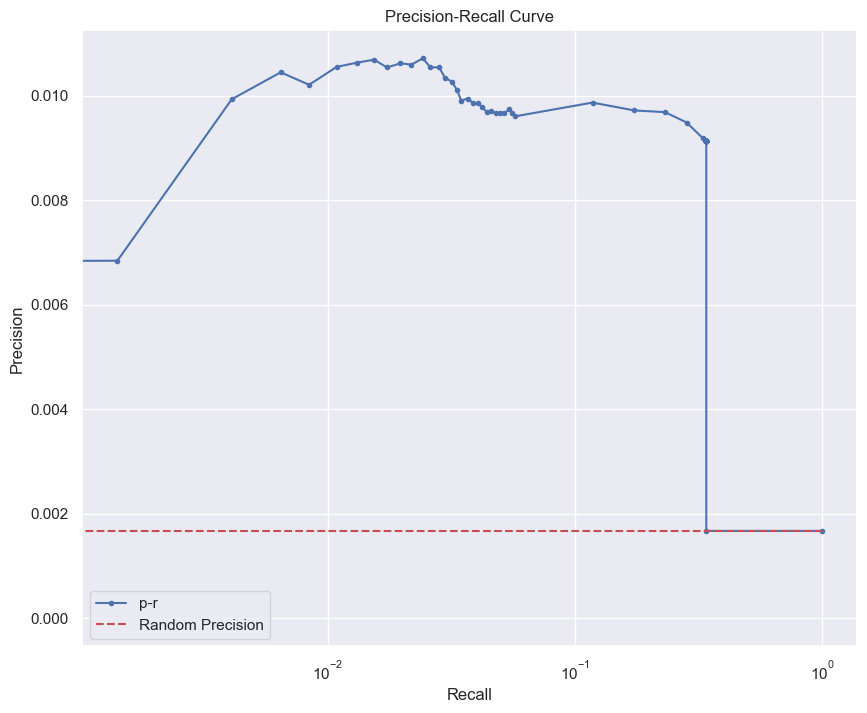

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/84 [00:00<?, ?it/s]

podocyte (334, 5000)
base enrichment
Top central genes: []


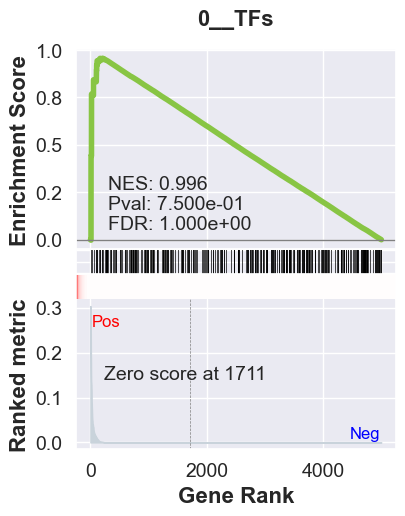

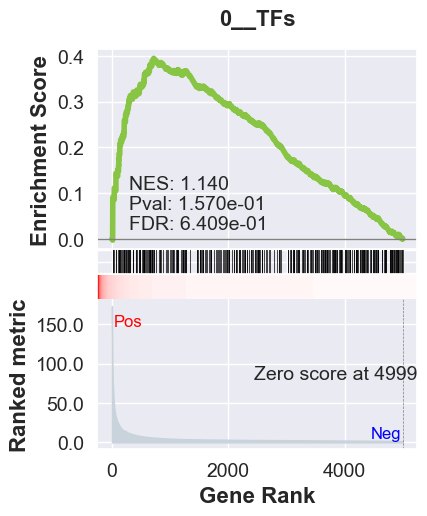

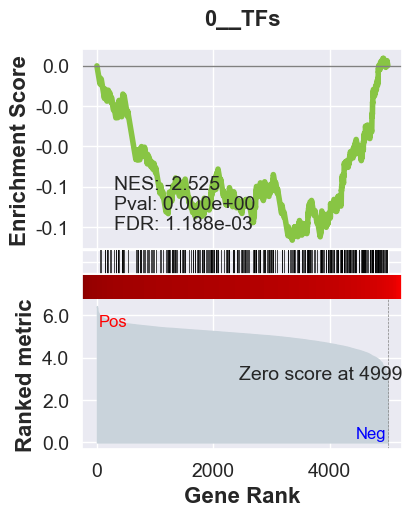

_________________________________________
TF specific enrichment
found some significant results for  8.51063829787234 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3603 genes
intersection pct: 0.7206
precision:  0.0015218365437682177 
recall:  0.940618179972593 
random precision: 0.001518183918238287


 98%|█████████▊| 126/128 [00:02<00:00, 51.57it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.27it/s]


Average Precision (AP):  0.0016130271400867958
Area Under Precision-Recall Curve (AUPRC):  0.0016122150936223652
EPR: 1.2042447463130395


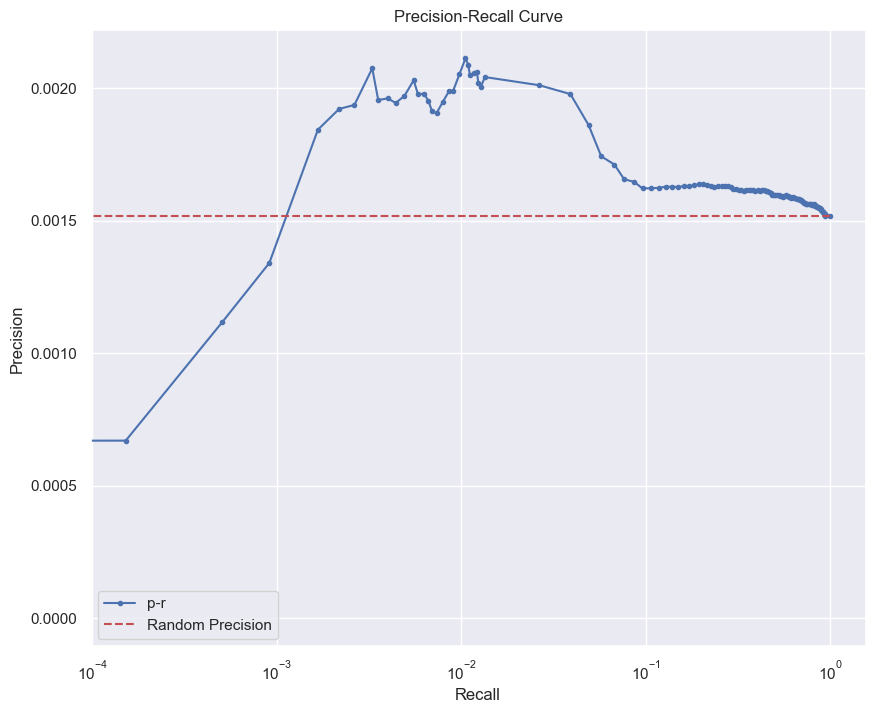

base enrichment
Top central genes: []


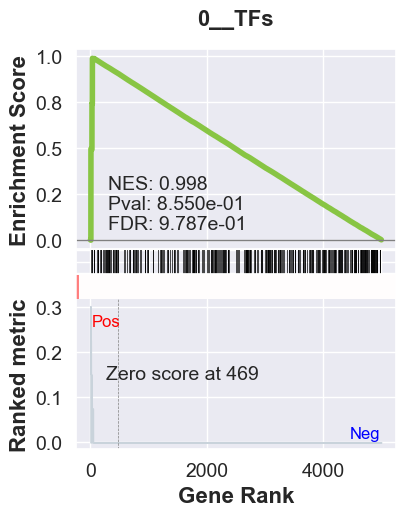

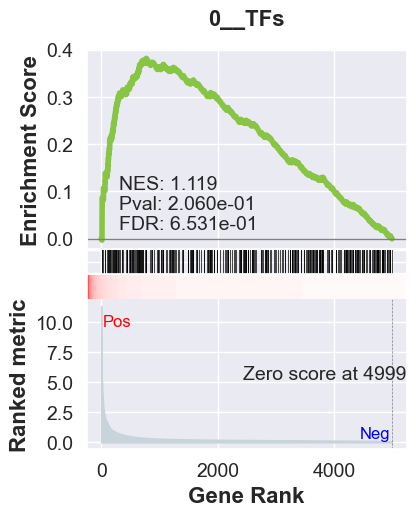

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3603 genes
intersection pct: 0.7206
precision:  0.008450675315078615 
recall:  0.4179059026544181 
random precision: 0.001518183918238287


 97%|█████████▋| 124/128 [00:02<00:00, 51.42it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.20it/s]


Average Precision (AP):  0.005376904796046023
Area Under Precision-Recall Curve (AUPRC):  0.004715073155448404
EPR: 6.803323997008373


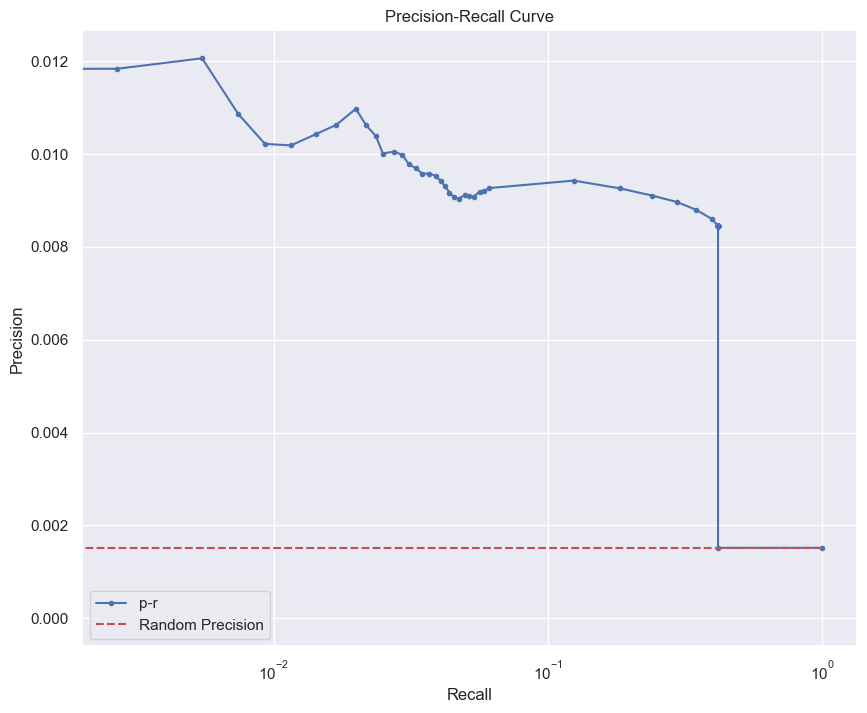

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/11 [00:00<?, ?it/s]

macrophage (41, 5000)
base enrichment
Top central genes: []


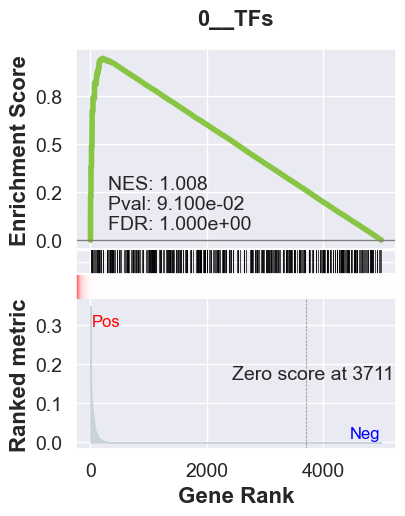

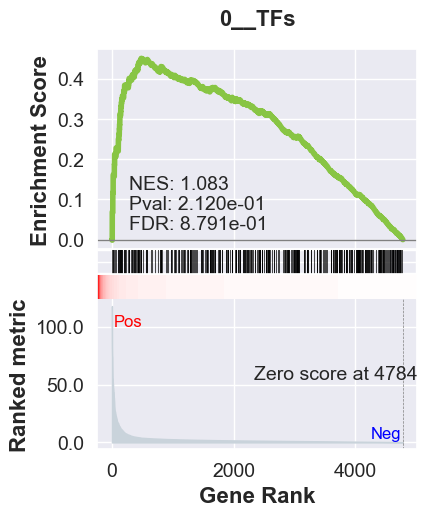

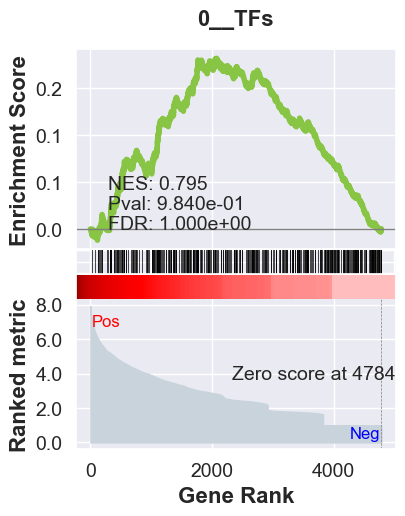

_________________________________________
TF specific enrichment
found some significant results for  17.073170731707318 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3553 genes
intersection pct: 0.7106
precision:  0.0016788950937943192 
recall:  0.4372986444593034 
random precision: 0.0013035393259851465


 98%|█████████▊| 126/128 [00:02<00:00, 54.03it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 53.82it/s]


Average Precision (AP):  0.0016013118612871466
Area Under Precision-Recall Curve (AUPRC):  0.0015214889730167198
EPR: 1.9164723394758254


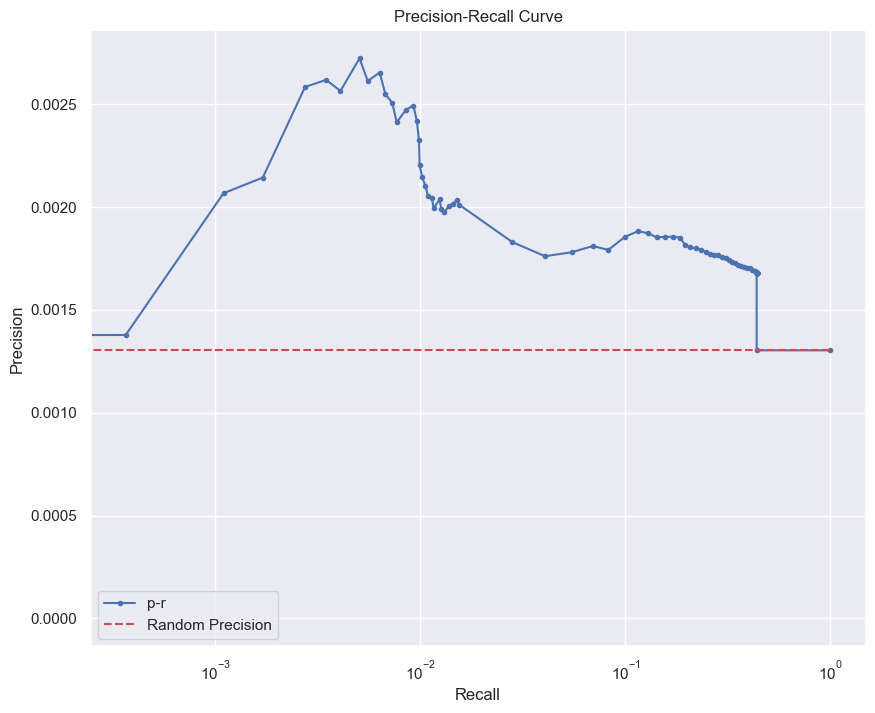

base enrichment
Top central genes: []


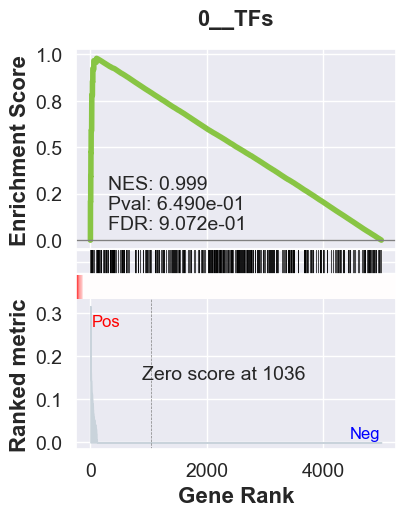

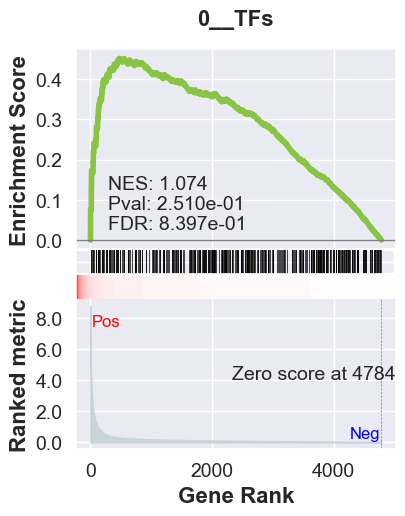

_________________________________________
TF specific enrichment
found some significant results for  9.75609756097561 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3553 genes
intersection pct: 0.7106
precision:  0.00963427454894923 
recall:  0.2205944927360039 
random precision: 0.0013035393259851465


 98%|█████████▊| 126/128 [00:02<00:00, 54.64it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.42it/s]


Average Precision (AP):  0.00404440706769466
Area Under Precision-Recall Curve (AUPRC):  0.003351689337461521
EPR: 8.850048946282318


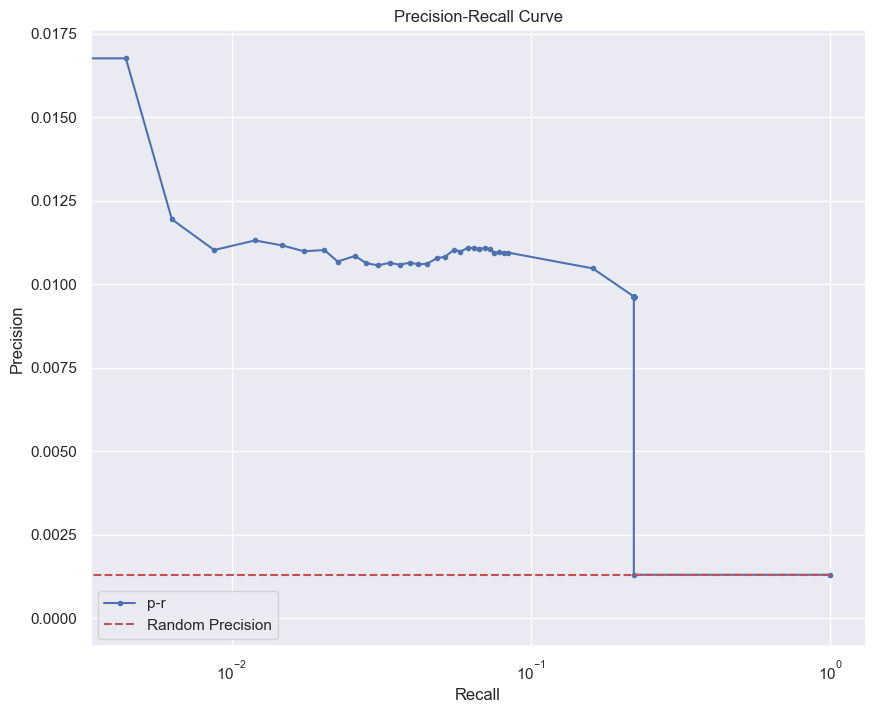

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/49 [00:00<?, ?it/s]

leukocyte (193, 4438)
base enrichment
Top central genes: []


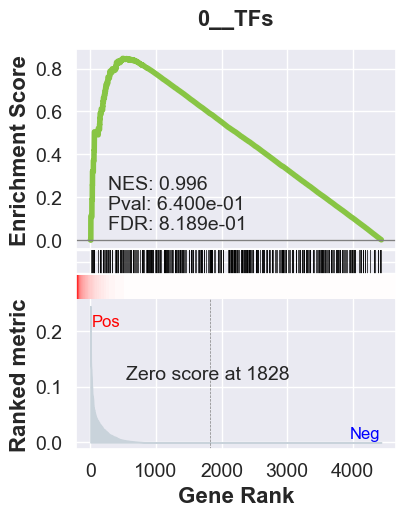

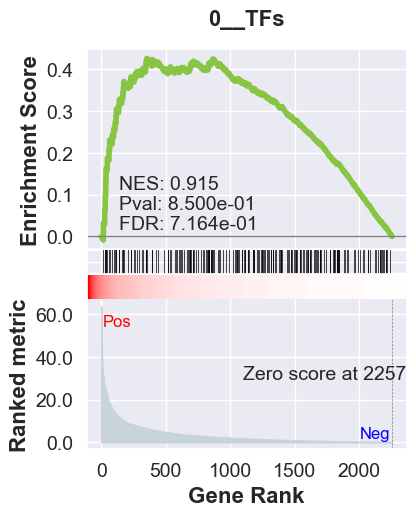

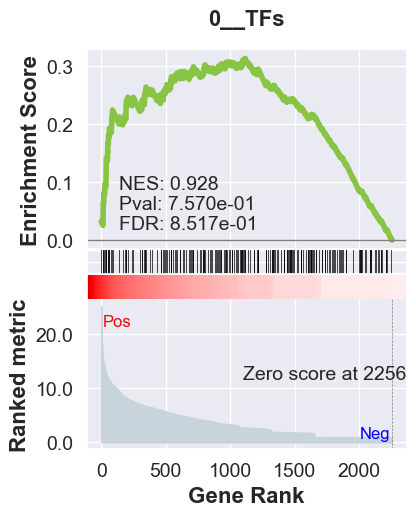

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2564 genes
intersection pct: 0.5777377196935557
precision:  0.0024096988502008082 
recall:  0.13741438356164384 
random precision: 0.0010664179981167254


 95%|█████████▍| 121/128 [00:01<00:00, 108.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 108.18it/s]


Average Precision (AP):  0.0017882582705250438
Area Under Precision-Recall Curve (AUPRC):  0.0012597313415325432
EPR: 2.1461375930124786


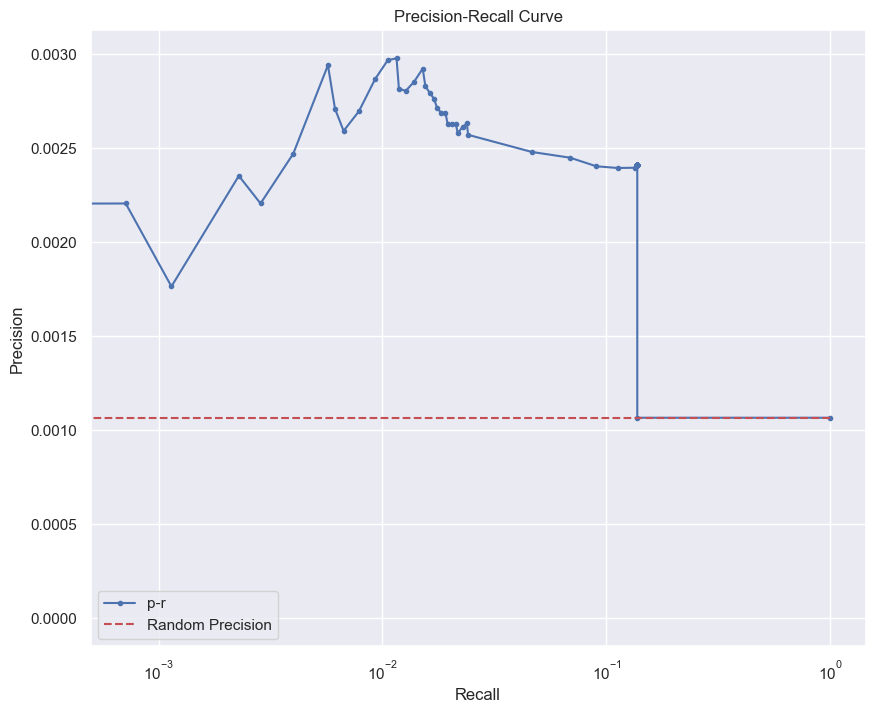

base enrichment
Top central genes: []


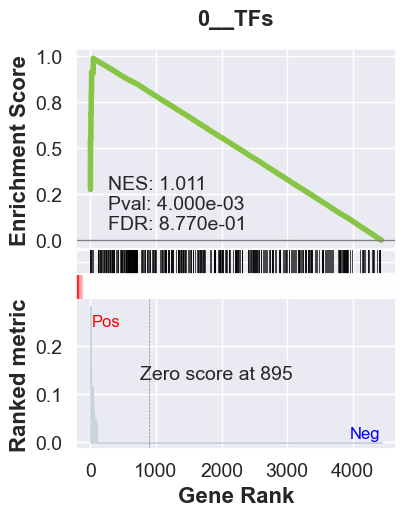

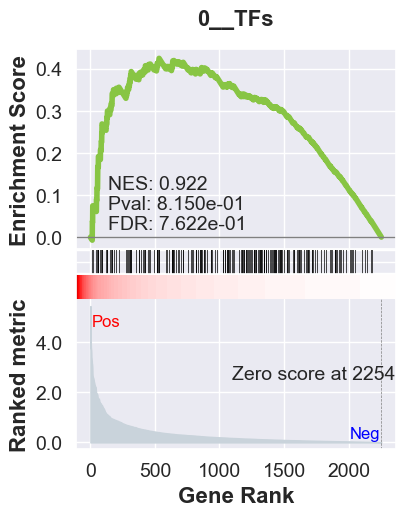

_________________________________________
TF specific enrichment
found some significant results for  4.761904761904762 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2564 genes
intersection pct: 0.5777377196935557
precision:  0.013892947867724749 
recall:  0.08818493150684932 
random precision: 0.0010664179981167254


 98%|█████████▊| 125/128 [00:01<00:00, 101.81it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 99.37it/s] 


Average Precision (AP):  0.0037594023406533807
Area Under Precision-Recall Curve (AUPRC):  0.002197230521809366
EPR: 14.875517580340265


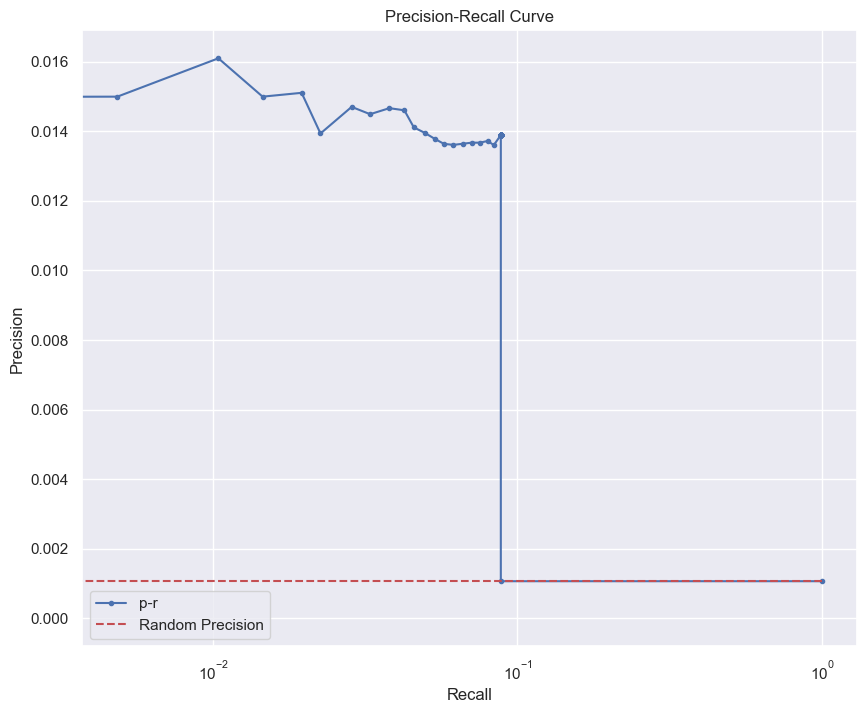

/tmp/ipykernel_137889/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/43 [00:00<?, ?it/s]

kidney interstitial fibroblast (170, 5000)
base enrichment
Top central genes: []


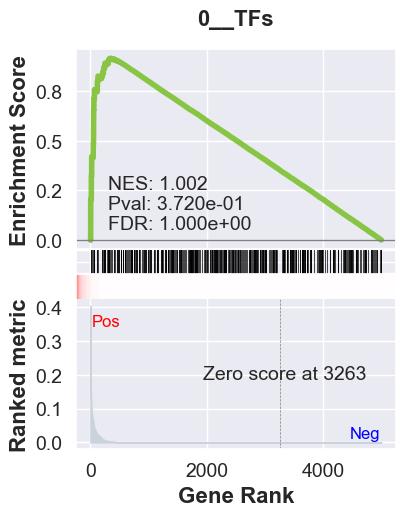

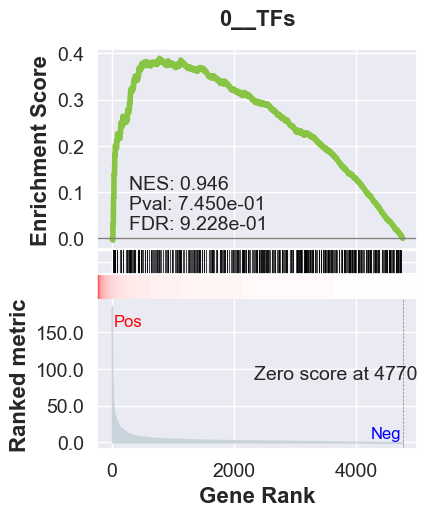

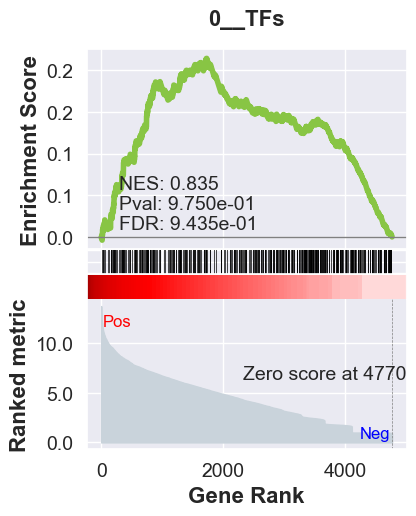

_________________________________________
TF specific enrichment
found some significant results for  4.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3540 genes
intersection pct: 0.708
precision:  0.0019605122547024945 
recall:  0.4688895979578813 
random precision: 0.0015009506659450864


 98%|█████████▊| 126/128 [00:02<00:00, 54.99it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.77it/s]


Average Precision (AP):  0.0018732775140567442
Area Under Precision-Recall Curve (AUPRC):  0.0018011552722641362
EPR: 1.5615888271102605


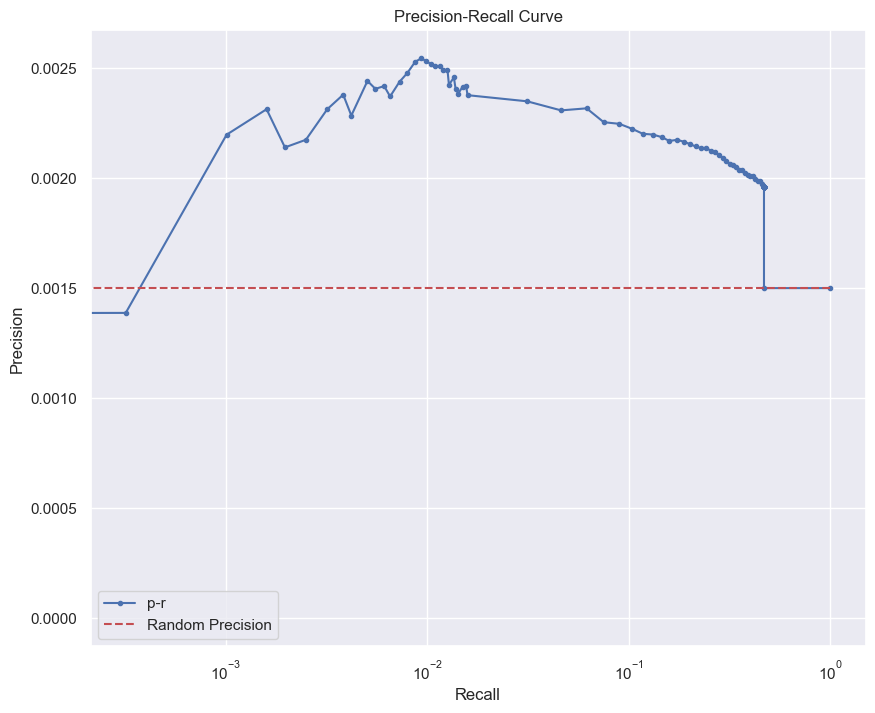

base enrichment
Top central genes: []


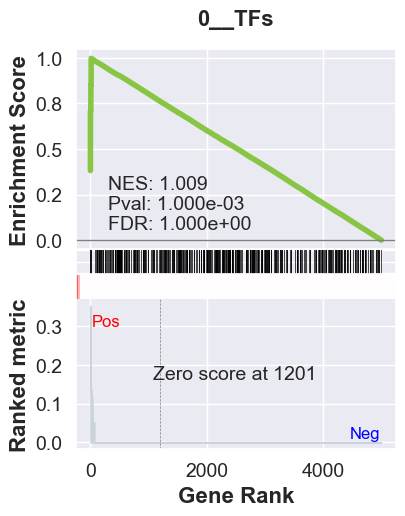

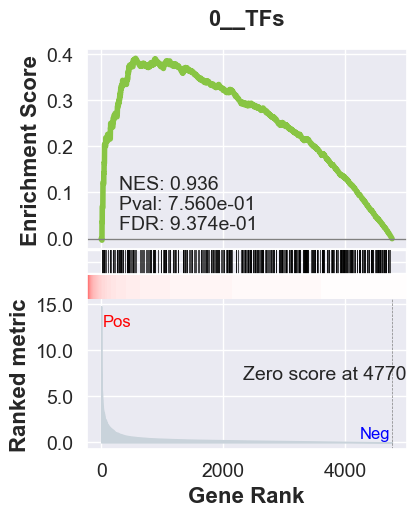

_________________________________________
TF specific enrichment
found some significant results for  4.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3540 genes
intersection pct: 0.708
precision:  0.010596324070529059 
recall:  0.2457987662199532 
random precision: 0.0015009506659450864


 98%|█████████▊| 126/128 [00:02<00:00, 53.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 53.12it/s]


Average Precision (AP):  0.005266078512085199
Area Under Precision-Recall Curve (AUPRC):  0.003981199303386163
EPR: 8.921943618920272


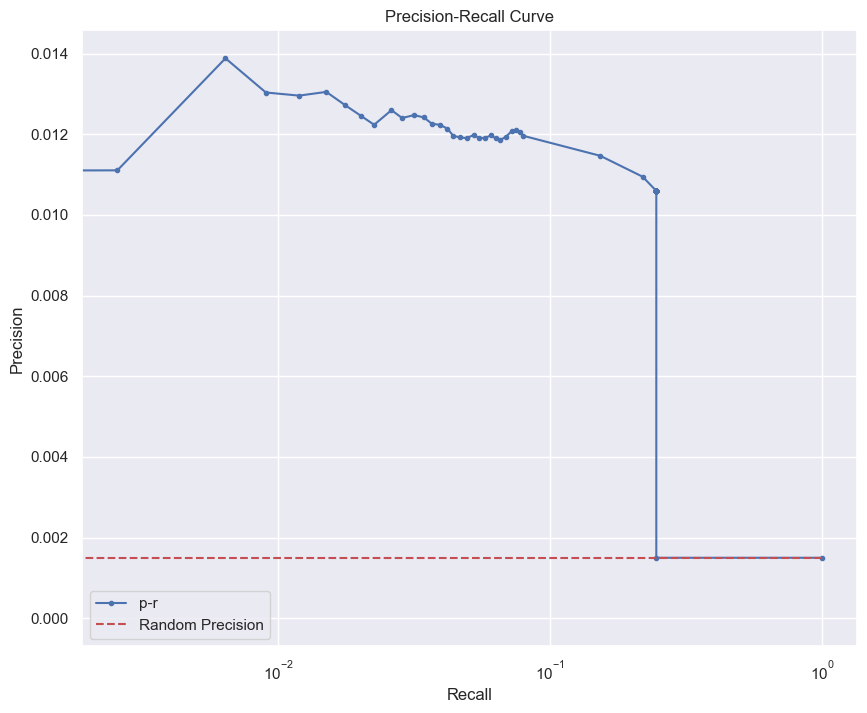

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500]
shapes = []
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS,  adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    print(celltype, grn.shape)
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    metrics['geneformer_tf_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
shapes

[5000, 5000, 5000, 4802, 5000, 5000, 5000, 4438, 5000]

In [8]:
metrics

{'geneformer_kidney distal convoluted tubule epithelial cell': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Distal tubule cells',
   'celltype.gmt__-intercalated cells (Collecting duct system)',
   'celltype.gmt__Connecting tubule cells',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Proximal tubule cells',
   'celltype.gmt__Delta cells'],
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0010623619711281117,
  'recall': 0.9992590397154713,
  'rand_precision': 0.001062203773751226,
  'auprc': 0.0011144952207096004,
  'ap': 0.0011154383276875675,
  'epr': 1.3963114708240703},
 'geneformer_tfkidney distal convoluted tubule epithelial cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 8.823529411764707,
  'precision': 0.004540668795146984,
  'recall': 0.33521043272080614,
  'rand_precision': 0.001062203773751226,
  'auprc': 0.002324228938821251,
  'ap': 0.0028625970113570244,
  'epr': 4.639463908997815},
 'gene

In [9]:
True
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
False
False


False

In [10]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,kidney distal convoluted tubule epithelial cell,1.396311,0.001114,0.001062,0.000000,False,False
1,tfkidney distal convoluted tubule epithelial cell,4.639464,0.002324,0.001062,8.823529,False,False
2,kidney loop of Henle thick ascending limb epit...,1.435071,0.001256,0.001212,2.500000,False,False
3,tfkidney loop of Henle thick ascending limb ep...,7.162509,0.003449,0.001212,2.500000,False,False
4,kidney collecting duct principal cell,1.169527,0.001446,0.001362,5.714286,False,False
5,tfkidney collecting duct principal cell,6.784703,0.004107,0.001362,2.857143,False,False
6,mesangial cell,2.027046,0.001336,0.001064,9.090909,False,False
7,tfmesangial cell,16.153948,0.003230,0.001064,2.272727,False,False
8,blood vessel smooth muscle cell,0.980184,0.001936,0.001672,12.500000,False,False
9,tfblood vessel smooth muscle cell,6.402975,0.004397,0.001672,1.785714,False,False
